# Modelling Wine Quality Based on Physicochemical Properties

## Introduction

Wine is a popular alcoholic beverage and is often rated based on its production quality and typicity, or how the wine can exhibit the style and traits of the region it’s from. Vinho verde is a wine that comes from the northern regions of Portugal. The white variety is characterised by its fresh acidity with an alcoholic content of 8.5% - 11%. The red variety tastes tannic and is more tart. Moreover, it tends to be lower in alcohol content, around 8%. 


For our project, we would like to answer the question: can we predict the quality rating of a vinho verde wine based on its physicochemical properties using the dataset available to us? We will only be using one wine quality dataset, focusing on the red variety of vinho verde wine. The datasets contain information about the physicochemical properties of vinho verde wines with quality ratings given by experts. Columns in our dataset include: fixed acidity (g / dm^3), volatile acidity ( g / dm^3), citric acid (g / dm^3), residual sugar (g / dm^3), chlorides (g / dm^3), free sulfur dioxide (mg / dm^3), total sulfur dioxide (mg / dm^3), density (g / cm^3), pH, sulphates (g / dm^3), alcohol (% by volume) and quality (score between 0 and 10). We choose to use all the columns as preliminary variables to conduct our analysis because these variables affect the production and flavour of wine. 

It is important to note the limitations of this dataset. None of the white wines have a rating of 1,2 or 10. Meanwhile, none of the red wines have a rating of 1,2,9 or 10. Therefore, the lowest rating we would expect to predict for red vinho verde wine is 3, and the highest rating we would expect to predict for red vinho verde is 8.

Word Count: 500

### Dataset Attributions

- P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


Data url : https://archive.ics.uci.edu/ml/datasets/Wine+Quality


## Methods

We will use both the K-nearest neighbours classification algorithm for our prediction model. In order to make the model, our methods include:

1. Load, clean, and wrangle our data using various wrangling functions

2. Randomly split the data into a training and testing set using `initial_split`, `training` and `testing`, and summarize the training data

3. Using the training set, we will determine which and how many of the predicting variables to use in our model by running a correlation plot, various visualizations, as well as a foward selection model. 

4. Create both models, tuning them if required:
- KNN requires standardization using `step_scale`, cross validation using `vfold_cv`, and K value tuning using `tune_grid`


5. Compute the accuracy of each model by testing it on the test data, and decide on the best model to use

6. Create a visualization of the best model using various visualization function

7. Predict the quality of a wine given an observation with an unknown rating

We hope to achieve an accuracy that is good enough to predict the quality of wine given an observation with an unknown rating. Our findings can help producers and sellers evaluate the quality of their products and can be useful for marketing or targeting consumer preferences. Relating to our work or wine quality classification, future analysis can explore what physicochemical variables affect wine quality the most.


## 1. Preliminary exploratory data analysis

In [ ]:
# Libaries
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

#### a) Demonstrate that the dataset can be read from the web into R, Clean and wrangle your data into a tidy format

In [ ]:
# Reading the data using read_delim 
# using read_delim and taking it from a url, however taking the csv file from the original website also works)

red_wine_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

red_data <- read_delim(red_wine_url, delim = ";")

red_data

**Table 1.** Determinant factors for the quality of red wine.

#### b) Clean and Wrangle Data

In [ ]:
# Changing column names so they have underscores using colnames, allowing us to be able to work with them

colnames(red_data) <- c("fixed_acidity", "volatile_acidity", "citric_acid", "residual_sugar", 
                             "chlorides", "free_sulfur_dioxide", "total_sulfur_dioxide", "density", 
                             "ph", "sulfates", "alcohol", "quality")


red_data

**Table 2.** Determinant factors for the quality of red wine. The column names have had the spaces replaced with underscores to allow for easier processing of data.

## 2. Split Data and Summarize

#### a) split data into training and testing

In [ ]:
#Let's split our data into testing and training data, and look at the training data so we can apply exploraty analysis
#Using set seed to allow for reproducibility 

set.seed(69)
red_split<-initial_split(red_data, prop=0.75, strata = quality)
red_train<-training(red_split)
red_test<-testing(red_split)

red_train

**Table 3.** Training data of the dataset pertaining to the contributors to the quality of red Vinho Verde wine.

#### b) Summarize the data into tables and visualizations

In [ ]:
#Let's summarize the data by figuring out how many wines are in each class (each quality ranking)
set.seed(69)
red_wine_quality_count<- red_train %>% 
                       group_by(quality) %>%
                       summarize(count = n())
red_wine_quality_count


**Table 4.** Number of red wines that fall within each level of quality.

## 3. Predictor Variable Selection (KNN Regression)

#### a) Let's make some visualizations to see how different variables affect eachother, and how they relate to the class (quality)

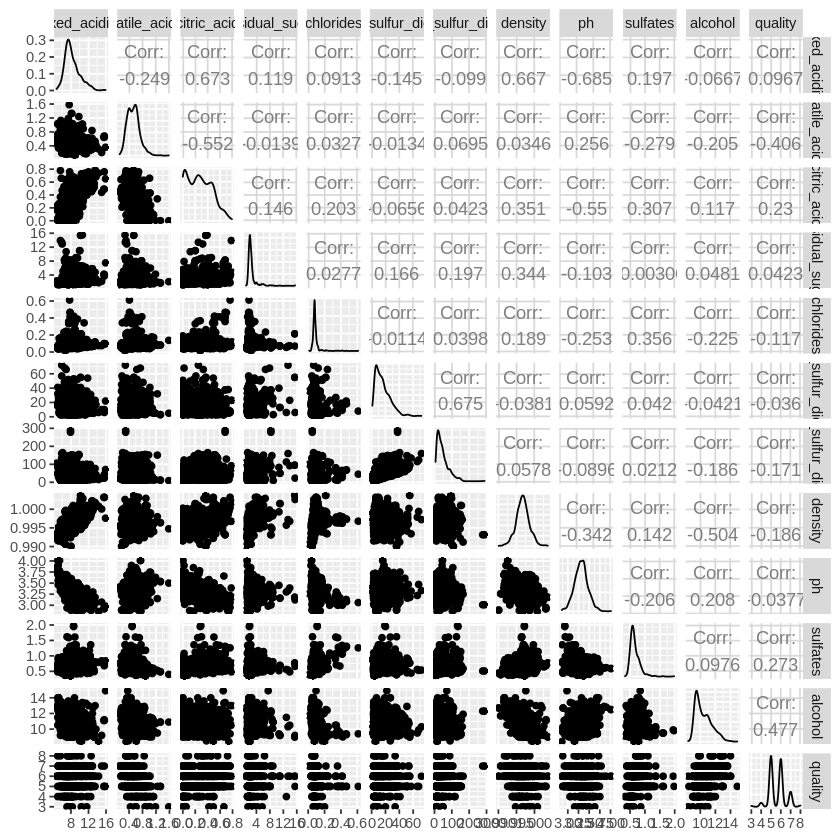

In [51]:
#Let's use the ggpairs function to determine which variables are related to quality the most, to begin deciding what we want to use as predictor variables

#First, we need to mutate 
set.seed(69)
red_plot_intro<- ggpairs(red_train)

red_plot_intro

As we can see, for red wines, alcohol (0.477), sulfates (0.273), citric acidity (0.23), and volatile acidity (-0.406) have the highest correlation coefficients.

Let's look at an exploratory visualization of the two most strongly correlated variables and quality:


##### Note: We need to mutate the quality function to `as_factor` for classifcation to work. We left it as dbl until now so that the ggpairs function to work:

In [52]:
#Let's do that right now

red_train <- red_train %>%
    mutate(quality = as_factor(quality))

red_test<-red_test%>%
mutate(quality = as_factor(quality))

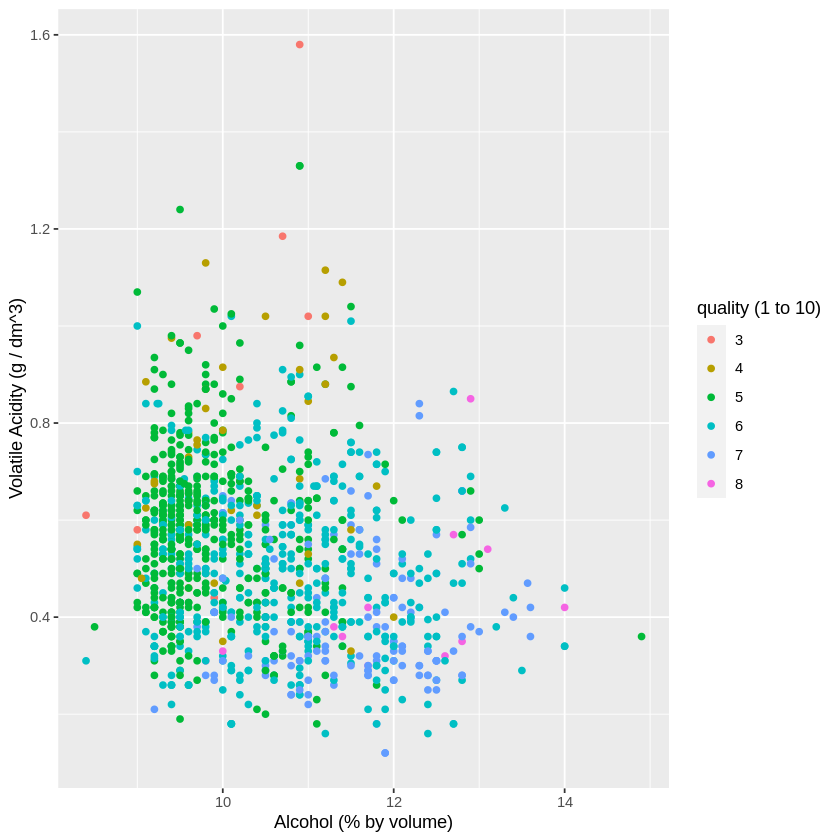

In [53]:
#Create a ggplot between alcohol and volatile acidity, using quality as color

red_plot_initial<-ggplot(red_train, aes(x = alcohol, y = volatile_acidity, color = quality))+
geom_point()+
labs(x = "Alcohol (% by volume)", y = "Volatile Acidity (g / dm^3)", color = "quality (1 to 10)" )

red_plot_initial

**Figure 2.** Visualiation of how acohol (% by volume) and volatile acidity (g/dm^3) relate to quality

We can see that increasing alcohol shows a positive correlation with quality level. It is a little harder to visualize but there also seems to be a weak negative relationship between volatile acidity and quality

#### b) Apply forward selection to figure out the best selection of predictors based on the highest correlating variables from above

In [54]:
#Let's now go through forward selection to figure out the best selection of predictors

#Select the variables mentioned above (the top 4 variables for each wine level) and extract column names
wine_r_subset <- red_train %>%
  select(quality, 
         alcohol, 
         sulfates, 
         citric_acid, 
         volatile_acidity)

names <- colnames(wine_r_subset %>%
                  select(-quality))

wine_r_subset

quality,alcohol,sulfates,citric_acid,volatile_acidity
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
5,9.8,0.68,0.00,0.88
5,9.8,0.65,0.04,0.76
5,9.4,0.56,0.00,0.70
⋮,⋮,⋮,⋮,⋮
5,10.5,0.58,0.08,0.60
6,11.2,0.76,0.10,0.55
6,11.0,0.66,0.47,0.31


In [55]:
# Forward Selection

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
                             set_engine("kknn") %>%
                             set_mode("classification")

# create a 5-fold cross-validation object
red_vfold <- vfold_cv(wine_r_subset, v = 5, strata = quality)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("quality", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        red_recipe <- recipe(as.formula(model_string), 
                                data = wine_r_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(red_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = red_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>% 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...

! Fold1: internal: No observations were detected in `truth` for level(s): '8'
Com...



size,model_string,accuracy
<int>,<chr>,<dbl>
1,quality ~ alcohol,0.5267156
2,quality ~ alcohol+volatile_acidity,0.6000882
3,quality ~ alcohol+volatile_acidity+sulfates,0.6008728
4,quality ~ alcohol+volatile_acidity+sulfates+citric_acid,0.5934110


**Table 5.** Figure showing each combination of predictors and their relative accuracy

The best combination of predictors to choose from is alcohol, volatile acidity, sulfates, and citric acid, 

## 4. Creating our KNN and Linear Regression Models

#### a) create the recipe, model spec, and run the `workflow` and `collect_metrics`

In [ ]:
set.seed(420) # DO NOT REMOVE

# Create recipe
red_knn_recipe1 <- recipe(quality ~ alcohol + volatile_acidity + sulfates + citric_acid, data = red_train) %>%
                        step_center(all_predictors()) %>%
                        step_scale(all_predictors())

# Create a model specification
red_knn_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                      set_engine("kknn") %>%
                      set_mode("classification")

# Create 5-fold cross-validation object
red_vfold1 <- vfold_cv(red_train, v = 5, strata = quality)

# Put the recipe and model specification together in a workflow.
red_knn_workflow1 <- workflow() %>%
                        add_recipe(red_knn_recipe1) %>%
                        add_model(red_knn_spec1)

# Run cross-validation for a grid of numbers of neighbors ranging from 1 to 400
gridvals1 <- tibble(neighbors = seq(1, 30))

red_knn_results1 <- red_knn_workflow1 %>%
                       tune_grid(resamples = red_vfold1, grid = gridvals1) %>%
                       collect_metrics() 

red_knn_results1

#### b) Visualize how the accuracy changes with k values

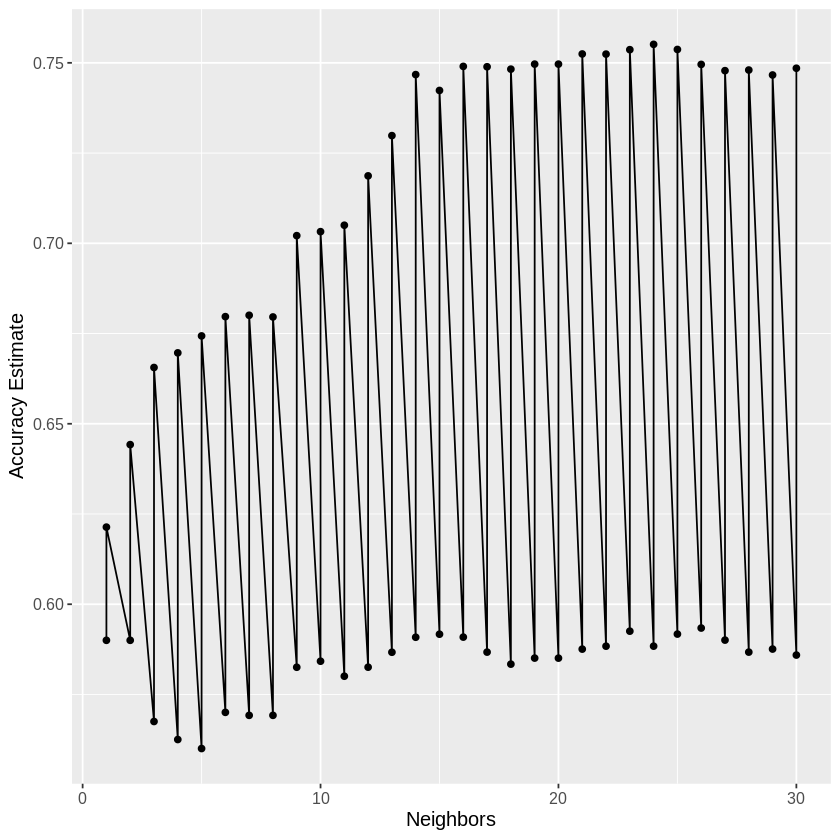

In [57]:
accuracy_vs_k <- ggplot(red_knn_results1, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

#### c) collect the k value with the highest accuracy and run your model again using the new k value and predict on the test data

In [58]:
#select the value of k resulting in best RMSE
kmax1 <- red_knn_results1 %>%
               filter(.metric == 'accuracy') %>%
               arrange(desc(mean)) %>%
               slice(1) %>%
               pull(neighbors)
kmax1

red_class_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmax1) %>%
    set_engine("kknn") %>%
    set_mode("classification")

red_fit <- workflow() %>%
    add_recipe(red_knn_recipe1) %>%
    add_model(red_class_spec) %>%
    fit(red_train)

red_pred <- red_fit %>%
    predict(red_test) %>%
    bind_cols(red_test)

red_pred

[1] 26

.pred_class,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulfates,alcohol,quality
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
5,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
5,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,6.8,0.620,0.08,1.9,0.068,28,38,0.99651,3.42,0.82,9.5,6
6,6.3,0.510,0.13,2.3,0.076,29,40,0.99574,3.42,0.75,11.0,6
5,5.9,0.645,0.12,2.0,0.075,32,44,0.99547,3.57,0.71,10.2,5


In [59]:
red_metrics<-red_pred%>%
metrics(truth = quality, estimate = .pred_class)%>%
filter(.metric == "accuracy")

red_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.5438596


#### d) Let's visualize our model. Note, since we can only visualize using two predictors, we will choose alcohol and volatile acidity, the two predictors with the strongest correlation coefficients

In [ ]:
red_final_plot<-

In [60]:
red_confusion<-red_pred%>%
conf_mat(truth = quality, estimate = .pred_class)

red_confusion

          Truth
Prediction   3   4   5   6   7   8
         3   0   0   0   0   0   0
         4   0   0   0   0   0   0
         5   2   9 126  62   2   0
         6   0   4  41  81  36   5
         7   0   0   4  16  10   1
         8   0   0   0   0   0   0

## 5. Discuss our Results

## 6. References